In [1]:
from proper_mass_service import MassService
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
threads = 3
queue_len = 10
_lambda =  3.55
_mu = 1.5
p = 0.8
tick_size = 0.01


"""threads = 3
queue_len = 10
_lambda =  0.5
_mu = 1.5
p = 0.8
tick_size = 0.01"""
ms = MassService(threads, queue_len, _lambda, _mu, p, tick_size=tick_size)
events_num = 10000

In [3]:
ms.test(events_num)

In [4]:
print("processed")
print(len(ms.processed))
print("requeued")
print(len(ms.requeued))
print("thrown away")
print(len(ms.thrown_away))

processed
9296
requeued
2140
thrown away
705


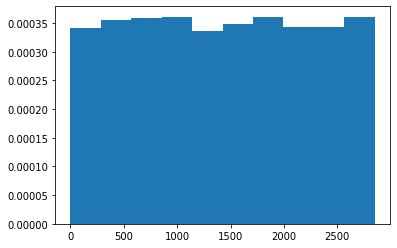

In [5]:
proc = [p.processed_time for p in ms.processed]
_ =plt.hist(proc, density=True)

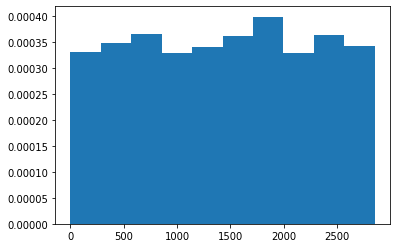

In [6]:
req = [r.processed_time for r in ms.requeued]
_ = plt.hist(req, density=True)

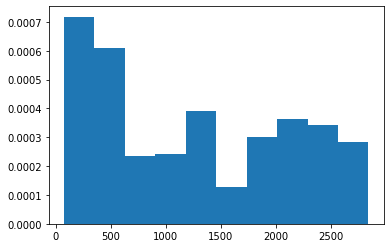

In [7]:
ta = [t.processed_time for t in ms.thrown_away]
_ = plt.hist(ta, density=True)

### среднее время в системе (в размерности, которую указывали)

In [8]:
def count_average_time_in_system():
    ls = []
    for event in ms.processed:
        ls.append(event.processed_time - event.spawn_time)
    for event in ms.thrown_away:
        ls.append(event.processed_time - event.spawn_time)
    #print(np.mean(ls))
    return np.mean(ls)

In [9]:
avg_time = count_average_time_in_system()
print("average time in system in intermediate ticks", avg_time)

average time in system in intermediate ticks 1.8858599557855469


### всего прошло тактов

In [10]:
time_passed = ms.intermediate_last_tick
print("time passed", time_passed)

time passed 285158


### практические финальные вероятности

In [11]:
def count_finite_possibilities(ms):
    length = threads + queue_len + 1
    s_0_n_nm = [0 for i in range (length)]
    for i in range(len(ms.events_in_queue_by_tick)): # i is the same for this and queue events sizes
        index = ms.events_in_queue_by_tick[i] + ms.events_processing_by_tick[i] #- 1
        s_0_n_nm[index] += 1
    
    all_states = sum(s_0_n_nm)
    possibilities = [s_0_n_nm[i] / all_states for i in range(len(s_0_n_nm))]
    return possibilities

14


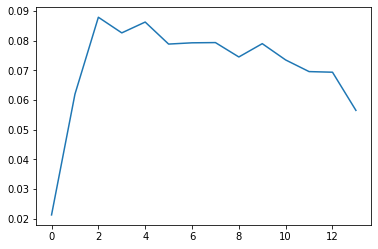

In [12]:
finite_states = count_finite_possibilities(ms)
print(len(finite_states))
_ = plt.plot(range(len(finite_states)), finite_states)
#_ = plt.hist(finite_states, bins=14)#len(finite_states))

In [13]:
def get_processed_frequency(processed, events_num):
    return len(processed) / events_num

In [14]:
processed_frequency = get_processed_frequency(ms.processed, events_num)
print("processed frequency", processed_frequency)

processed frequency 0.9296


In [15]:
requeue_frequency = len(ms.requeued) / events_num # not a probability
print("requeue frequency", requeue_frequency)

requeue frequency 0.214


In [16]:
def get_thrown_frequency(thrown_away, events_num):
    return len(thrown_away) / events_num

In [17]:
thrown_frequency = get_thrown_frequency(ms.thrown_away, events_num)
print("thrown away frequency", thrown_frequency)

thrown away frequency 0.0705


working threads in time


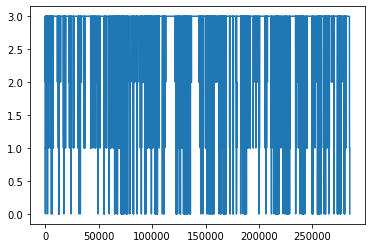

In [18]:
print("working threads in time")
#plt.xlim((500, 550))
_ = plt.plot(range(len(ms.events_processing_by_tick)), ms.events_processing_by_tick)

### поковыряемся с теоретическими значениями

### говорят, когда система без качества обслуживания (p < 1), вероятность обслужить влияет на частоту выходного потока, поэтому λ/μ = ρ превращается в λ/(μ*p) = ρ

In [19]:
def get_rho(_lambda, _mu, p):
    return _lambda / (_mu * p)

In [20]:
_rho = get_rho(_lambda, _mu, p)
print("λ/(μ*p) = ρ =", _rho)

λ/(μ*p) = ρ = 2.9583333333333326


In [21]:
def get_free_probability(_rho, n, m):
    p0 = 1
    
    
    for k in range(1, n + 1):
        p0 += _rho**k / math.factorial(k)
    
    p0 += _rho**(n + 1) * (1 - (_rho / n)**m) / (n * math.factorial(n) * (1 - _rho / n))
    
    return 1 / p0


def get_state_probs(_rho, p, n, m):
    #print(ρ)
    
    p0 = get_free_probability(_rho, n, m)
    #print(p0)
    probs = [p0]
    
    for k in range(1, n + 1):
        probs.append(_rho**k / math.factorial(k) * p0)
    
    for k in range(1, m + 1):
        probs.append(_rho**(n + k) / ( n**k * math.factorial(n)) * p0)
    
    return probs

In [22]:
theor_probs = get_state_probs(_rho, p, threads, queue_len)

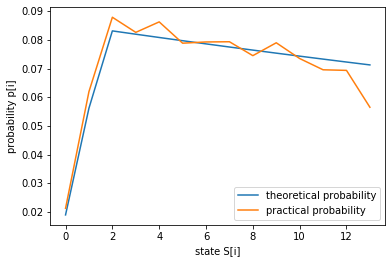

In [23]:
plt.xlabel('state S[i]')
plt.ylabel('probability p[i]')

lenghts = range(len(finite_states))
#plt.xlim()
#plt.xticks(range(len(finite_states)))
plt.plot(lenghts, theor_probs, label='theoretical probability');
plt.plot(lenghts, finite_states, label='practical probability');
plt.legend();

### вероятность выкинуть заявку из обслуживания (совсем отказ)

In [24]:
def get_throw_prob(_rho, n, m):
    p0 = get_free_probability(_rho, n, m)
    return _rho**(n + m)  / (n**m * math.factorial(n)) * p0

In [25]:
theor_cancel_prob = get_throw_prob(_rho, threads, queue_len)
theor_relative_bandwidth = 1 - theor_cancel_prob
theor_absolute_bandwidth = _lambda * theor_relative_bandwidth

In [26]:
print('theoretical throw-out probability:', theor_cancel_prob)
print('practical throw-out probability:', thrown_frequency)

theoretical throw-out probability: 0.07127755574368404
practical throw-out probability: 0.0705


### посчитаем среднюю длину очереди

In [27]:
def get_theor_queue_len(_rho, n, m):
    p0 = get_free_probability(_rho, n, m)
    return p0 * _rho**(n + 1) / (n * math.factorial(n)) * sum(k * (_rho / n)**(k - 1) for k in range(1, m + 1))


In [28]:
theor_queue_size = get_theor_queue_len(_rho, threads, queue_len)
avg_queue_length = np.mean(ms.events_in_queue_by_tick)

In [29]:
print('theoretical queue length:', theor_queue_size)
print('practical queue length:', avg_queue_length)

theoretical queue length: 4.090669962582558
practical queue length: 3.9063119172110996


### посчитаем среднее количество одновременно занятых потоков

In [30]:
def get_average_working_threads_count(_rho, bandwidth):
    return _rho * theor_relative_bandwidth

In [31]:
theor_working_threads = get_average_working_threads_count(_rho, theor_relative_bandwidth)
avg_working_threads = np.mean(ms.events_processing_by_tick)

In [32]:
print('theoretical average working threads:', theor_working_threads)
print('practical average working threads:', avg_working_threads)

theoretical average working threads: 2.7474705642582675
practical average working threads: 2.724273124818084


### посчитаем среднее количество событий в момент времени, находящихся на обслуживании

In [33]:
def get_average_events(queue_size, working_threads):
    return queue_size + working_threads

In [34]:
theor_events_in_system = get_average_events(theor_queue_size, theor_working_threads)
avg_events_in_system = np.mean(ms.events_in_system_by_tick)

In [35]:
print('theoretical average events in system:', theor_events_in_system)
print('practical average events in system:', avg_events_in_system)

theoretical average events in system: 6.838140526840825
practical average events in system: 6.630585042029184


### динамика работы СМО

In [36]:
def run_with_events(n, m, _lambda, _mu, p, tick_size, event_count):
    ms = MassService(n, m, _lambda, _mu, p, tick_size)
    ms.test(event_count)
    
    throw_out_frequency = get_thrown_frequency(ms.thrown_away, event_count)
    relative_bandwidth = 1 - throw_out_frequency
    absolute_bandwidth = relative_bandwidth * _lambda
    
    finite_states = count_finite_possibilities(ms)
    lims = range(len(finite_states))
    
    _rho = get_rho(_lambda, _mu, p)
    theor_probs = get_state_probs(_rho, p, threads, queue_len)
    
    theor_cancel_prob = get_throw_prob(_rho, threads, queue_len)
    theor_relative_bandwidth = 1 - theor_cancel_prob
    theor_absolute_bandwidth = _lambda * theor_relative_bandwidth
    
    theor_queue_size = get_theor_queue_len(_rho, threads, queue_len)
    avg_queue_length = np.mean(ms.events_in_queue_by_tick)
    
    theor_working_threads = get_average_working_threads_count(_rho, theor_relative_bandwidth)
    avg_working_threads = np.mean(ms.events_processing_by_tick)
    
    theor_events_in_system = get_average_events(theor_queue_size, theor_working_threads)
    avg_events_in_system = np.mean(ms.events_in_system_by_tick)
    
    return throw_out_frequency, relative_bandwidth, theor_relative_bandwidth,\
           absolute_bandwidth, theor_absolute_bandwidth, lims,\
           avg_queue_length, theor_queue_size, \
           avg_working_threads, theor_working_threads, \
           avg_events_in_system, theor_events_in_system, \
           finite_states

In [37]:
info = []
sizes = [100, 1000, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000]
for i in sizes:
    info.append(run_with_events(threads, queue_len, _lambda, _mu, p, tick_size, i))

### частота отказов

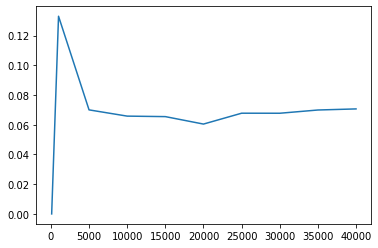

In [38]:
_ = plt.plot(sizes, [i[0] for i in info])

### относительная пропускная способность

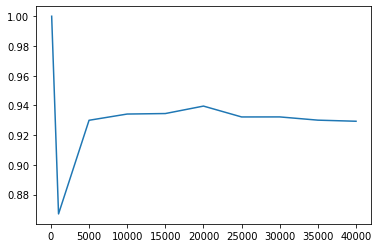

In [39]:
_ = plt.plot(sizes, [i[1] for i in info])

### абсолютная пропускная способность

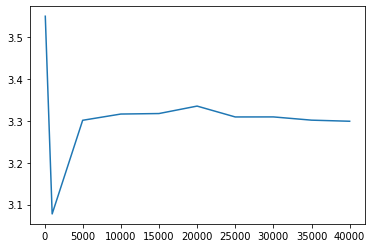

In [40]:
_ = plt.plot(sizes, [i[3] for i in info])

### средняя длина очереди

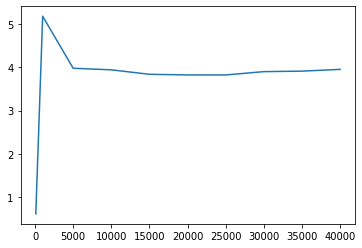

In [41]:
_ = plt.plot(sizes, [i[6] for i in info])

### среднее число занятых одновременно потоков

In [42]:
_ = plt.plot(sizes, [i[8] for i in info])

### среднее число событий, находящихся в системе одновременно

In [43]:
_ = plt.plot(sizes, [i[10] for i in info])

### вероятности состояний системы

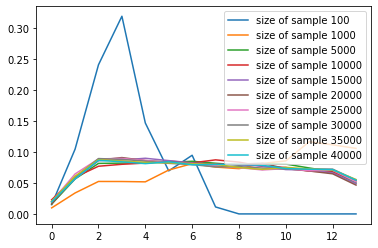

In [59]:
for i in range(len(info)):
    states = info[i][12]
    states_num = info[i][5]
    plt.plot(states_num, states, label=str('size of sample '+str(sizes[i])))
plt.legend()
plt.show()